In [1]:
# Dublin Bikes Data Analysis

In [2]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [3]:
data1 = pd.read_csv('C:/Users/Anna/Downloads/dublinbikes_20190401_20190701.csv')
data2 = pd.read_csv('C:/Users/Anna/Downloads/dublinbikes_20190701_20191001.csv')
data3 = pd.read_csv('C:/Users/Anna/Downloads/dublinbikes_20191001_20200101.csv')
data4 = pd.read_csv('C:/Users/Anna/Downloads/dublinbikes_20200101_20200401.csv')
data1.sample(5)

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
1745519,76,2019-05-24 00:10:02,2019-05-24 00:02:50,MARKET STREET SOUTH,38,13,25,Open,Market Street South,53.342297,-6.287661
1937924,66,2019-05-30 01:55:02,2019-05-30 01:43:59,NEW CENTRAL BANK,40,31,9,Open,New Central Bank,53.347122,-6.234749
661272,39,2019-04-21 11:25:04,2019-04-21 11:21:37,WILTON TERRACE,20,6,14,Open,Wilton Terrace,53.332382,-6.252717
562703,36,2019-04-18 05:20:03,2019-04-18 05:16:46,ST. STEPHEN'S GREEN EAST,40,36,4,Open,St. Stephen's Green East,53.337826,-6.256035
685517,9,2019-04-22 15:50:02,2019-04-22 15:47:08,EXCHEQUER STREET,24,0,24,Open,Exchequer Street,53.343033,-6.263578


In [4]:
#merge data into one table
data = pd.concat([data1,data2, data3,data4])
data = data[data['STATUS'] == 'Open']
data = data[(data['LAST UPDATED'] >= '2019-07-01') & (data['LAST UPDATED'] < '2020-04-01')]
data = data[(data['LAST UPDATED'] < '2019-12-01') | (data['LAST UPDATED'] >= '2020-02-01')]

#remove rows where no update actually occurs
data = data.drop(['TIME'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)


#get date and time columns
data['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["LAST UPDATED"]]
data['LAST UPDATED'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['DATE'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data['DATETIME'].dt.round('H')

#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['DAY_NUMBER'] = data.DATETIME.dt.dayofweek
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "


data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['HOUR'] = data['DATETIME'].dt.hour
data['MONTH'] = data['DATETIME'].dt.month
data['YEAR'] = data['DATETIME'].dt.year
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(5)



,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,YEAR,CLUSTER_GROUP
76088,43,04:37:58,PORTOBELLO ROAD,30,9,21,Open,Portobello Road,53.330090,-6.268044,...,0.700,0,0,2,Weekday,Overnight,4,7,2019,Overnight Weekday
484393,28,21:34:53,MOUNTJOY SQUARE WEST,30,3,27,Open,Mountjoy Square West,53.356300,-6.258586,...,0.900,0,0,3,Weekday,8PM-11PM,21,2,2020,8PM-11PM Weekday
2043691,23,01:43:08,CUSTOM HOUSE,30,18,12,Open,Custom House,53.348278,-6.254662,...,0.400,0,0,4,Weekday,Overnight,1,3,2020,Overnight Weekday
2061912,90,08:05:32,BENSON STREET,40,31,9,Open,Benson Street,53.344154,-6.233451,...,0.225,0,0,4,Weekday,6AM-10AM,8,3,2020,6AM-10AM Weekday
520973,19,07:43:55,HERBERT PLACE,30,5,24,Open,Herbert Place,53.334431,-6.245575,...,0.800,0,0,2,Weekday,6AM-10AM,7,7,2019,6AM-10AM Weekday


In [5]:
### Prepare Weather Data

weather = pd.read_csv('C:/Users/Anna/Downloads/dublin_bikes-main/hly175.csv')
weather['date'] = [dt.datetime.strptime(d, "%m/%d/%Y %H:%M") for d in weather['date'] ]
weather['date_for_merge'] = weather['date'].dt.round('H')
weather = weather[(weather['date'] >= '2019-04-01') & (weather['date'] < '2020-04-02')]
weather = weather[['date_for_merge', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']]
weather['rain'] = weather['rain'].astype(float)
weather['temp'] = weather['temp'].astype(float)

#add binary variables to note wet/dry weather and hot or not days (temperature)
weather['dry'] = np.where(weather['rain'] > 0.0, 1, 0)
weather['warm'] = np.where(weather['temp'] > 18.0, 1, 0)
weather.sample(5)


,date_for_merge,rain,temp,wetb,dewpt,vappr,rhum,msl,dry,warm
116425,2019-12-29 02:00:00,0.0,11.5,9.8,8.0,10.7,79,1025.7,0,0
114281,2019-09-30 18:00:00,0.7,12.5,12.3,12.1,14.1,97,997.8,1,0
111163,2019-05-23 20:00:00,0.0,14.6,12.5,10.6,12.8,77,1017.2,0,0
115529,2019-11-21 18:00:00,0.0,7.2,5.8,3.9,8.1,79,997.4,0,0
111268,2019-05-28 05:00:00,0.0,8.5,7.6,6.6,9.8,88,1013.1,0,0


In [6]:
#merge weather with bikes data
merged_data = pd.merge(data, weather, on = 'date_for_merge', how = 'left')

# identify bike arrivals and bike departures
merged_data['BIKE_ARR_DEP'] = merged_data.groupby('STATION ID')['AVAILABLE BIKE STANDS'].diff(-1)
merged_data['BIKE_ARR'] = np.where(merged_data['BIKE_ARR_DEP'] > 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['BIKE_DEP'] = np.where(merged_data['BIKE_ARR_DEP'] < 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['ACTIVITY_TYPE'] = np.where(abs(merged_data['BIKE_ARR_DEP']) >= 10, "REBALANCING", "RENTAL")
merged_data['IMBALANCED'] = np.where(merged_data['OCCUPANCY_PCT'] < .1, 1, 
                                   np.where(merged_data['OCCUPANCY_PCT'] > .9, 1,0 ))

# Identify days with rebalancing
merged_data['REBALANCING'] = np.where(merged_data['ACTIVITY_TYPE'] == 'REBALANCING', 1,0)
merged_data['JOIN_ON'] = merged_data['STATION ID'].apply(str)  + (merged_data['DATE']).apply(str) 
join_table= merged_data.groupby(['JOIN_ON'])['REBALANCING'].sum()
merged_data = merged_data.drop(['REBALANCING'], axis = 1)
join_table = join_table.to_frame()
join_table =join_table.reset_index()
merged_data = pd.merge(merged_data, join_table, on = 'JOIN_ON', how = 'left')
merged_data = merged_data.drop(['JOIN_ON'], axis = 1)

merged_data.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,rhum,msl,dry,warm,BIKE_ARR_DEP,BIKE_ARR,BIKE_DEP,ACTIVITY_TYPE,IMBALANCED,REBALANCING
3346369,94,18:53:40,HEUSTON STATION (CAR PARK),40,6,34,Open,Heuston Station (Car Park),53.346985,-6.297804,...,81,987.8,1,0,0.0,0.0,0.0,RENTAL,0,0
3821172,30,02:43:48,PARNELL SQUARE NORTH,20,16,4,Open,Parnell Square North,53.353462,-6.265305,...,90,1002.2,1,0,0.0,0.0,0.0,RENTAL,0,0
1707092,38,17:14:07,TALBOT STREET,40,35,5,Open,Talbot Street,53.350975,-6.252940,...,95,997.2,0,0,0.0,0.0,0.0,RENTAL,0,0
1332750,62,07:02:47,LIME STREET,40,30,10,Open,Lime Street,53.346027,-6.243576,...,89,1014.3,0,0,1.0,1.0,0.0,RENTAL,0,0
3355960,37,13:31:26,ST. STEPHEN'S GREEN SOUTH,30,25,5,Open,St. Stephen's Green South,53.337494,-6.261990,...,68,1005.1,1,0,0.0,0.0,0.0,RENTAL,0,0


### Time Clusters

In [7]:
#group data into clusters
clustering_df = merged_data[['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'DAY_TYPE', 'TIME_TYPE', 'OCCUPANCY_PCT','CLUSTER_GROUP']]
clustering_df = clustering_df.groupby(['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CLUSTER_GROUP'],as_index=False)['OCCUPANCY_PCT'].mean()
clustering_df  = clustering_df.set_index('STATION ID')

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['NAME', 'STATION ID','LATITUDE', 'LONGITUDE'] , columns=['CLUSTER_GROUP'], values='OCCUPANCY_PCT')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('NAME')
clustering_df = clustering_df.dropna()

clustering_df.sample(5)

CLUSTER_GROUP,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday
NAME,,,,,,,,,,,,,,,,,,
ECCLES STREET,12,53.359245,-6.269779,0.130526,0.134685,0.125719,0.149754,0.172667,0.274690,0.170657,0.147077,0.194210,0.149570,0.251293,0.470375,0.326540,0.238443,0.548919
DEVERELL PLACE,45,53.351463,-6.255265,0.789905,0.808794,0.181395,0.841687,0.828547,0.543425,0.777307,0.840546,0.307376,0.835619,0.816551,0.730647,0.811965,0.838480,0.744690
OLIVER BOND STREET,74,53.343891,-6.280531,0.414264,0.363549,0.213009,0.429845,0.346627,0.478114,0.479585,0.491937,0.249845,0.488702,0.415406,0.649096,0.607283,0.532613,0.669545
FITZWILLIAM SQUARE EAST,89,53.335213,-6.250900,0.113492,0.126111,0.676296,0.110498,0.126352,0.204736,0.076821,0.124469,0.421400,0.117917,0.131692,0.060433,0.082242,0.113746,0.061768
CUSTOM HOUSE,23,53.348278,-6.254662,0.803079,0.795987,0.371974,0.696232,0.674518,0.766771,0.650581,0.655297,0.333025,0.662245,0.425856,0.534040,0.525053,0.538902,0.294560


### K-Means Clustering Analysis

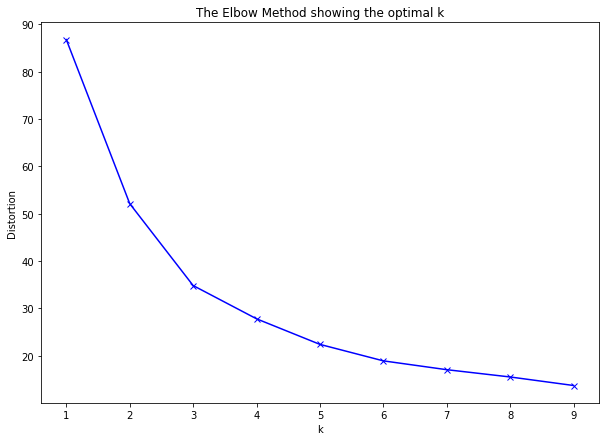

In [8]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [9]:
#clustering algo
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
KM = KMeans(n_clusters=5) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()
locations.head(5)

CLUSTER_GROUP,NAME,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster
0,AVONDALE ROAD,108,53.359406,-6.276142,0.159102,0.126197,0.107060,0.208063,0.183721,0.247766,0.279970,0.168737,0.154918,0.206872,0.252699,0.369088,0.390925,0.243118,0.421789,0
1,BARROW STREET,70,53.341656,-6.236198,0.457221,0.129602,0.703599,0.091699,0.502551,0.163900,0.593277,0.249084,0.730308,0.119338,0.753040,0.218540,0.287356,0.247592,0.315751,2
2,BENSON STREET,90,53.344154,-6.233451,0.178727,0.142477,0.655158,0.125685,0.142831,0.091801,0.225119,0.190721,0.735708,0.134686,0.166334,0.059702,0.093759,0.161444,0.109268,2
3,BLACKHALL PLACE,88,53.348801,-6.281637,0.375960,0.442651,0.131210,0.439610,0.480735,0.409125,0.559444,0.566730,0.237267,0.556918,0.625755,0.760816,0.730187,0.657854,0.828303,4
4,BLESSINGTON STREET,2,53.356770,-6.268140,0.177049,0.079175,0.118073,0.170406,0.188239,0.248699,0.164333,0.129490,0.161376,0.206522,0.278690,0.482975,0.420940,0.282905,0.545053,0


In [10]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.5)
for LATITUDE, LONGITUDE, Cluster in zip(locations['LATITUDE'],locations['LONGITUDE'], locations['Cluster']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map
    

In [11]:
#merge clusters back into main dataset

merged_with_clusters = merged_data
cluster_output = locations[['STATION ID', 'Cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
del merged_data
merged_with_clusters = pd.merge (merged_with_clusters, cluster_output, on = 'STATION ID', how = 'left')
merged_with_clusters['BIKE_ARR_DEP_ABS'] = abs(merged_with_clusters['BIKE_ARR_DEP'])
merged_with_clusters.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,dry,warm,BIKE_ARR_DEP,BIKE_ARR,BIKE_DEP,ACTIVITY_TYPE,IMBALANCED,REBALANCING,Cluster,BIKE_ARR_DEP_ABS
2060157,106,21:23:27,RATHDOWN ROAD,40,29,11,Open,Rathdown Road,53.358929,-6.280337,...,0,0,0.0,0.0,0.0,RENTAL,0,0,0,0.0
4092666,32,20:56:53,PEARSE STREET,30,23,7,Open,Pearse Street,53.344303,-6.250427,...,0,0,0.0,0.0,0.0,RENTAL,0,0,1,0.0
4149666,85,09:51:36,ROTHE ABBEY,35,21,14,Open,Rothe Abbey,53.338776,-6.303950,...,0,0,0.0,0.0,0.0,RENTAL,0,0,3,0.0
1645564,19,10:21:04,HERBERT PLACE,30,1,29,Open,Herbert Place,53.334431,-6.245575,...,0,0,-1.0,0.0,-1.0,RENTAL,1,3,2,1.0
470919,107,03:29:35,CHARLEVILLE ROAD,40,14,26,Open,Charleville Road,53.359158,-6.281866,...,0,0,0.0,0.0,0.0,RENTAL,0,0,3,0.0


 ML Occupancy Percentage Classifier

In [12]:
from sklearn.preprocessing import OneHotEncoder
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(merged_with_clusters[['DAY_TYPE']]).toarray())
encoder_df.columns = ['day_cat1', 'day_cat2', 'day_cat3']
encoder_df2 = pd.DataFrame(encoder.fit_transform(merged_with_clusters[['TIME_TYPE']]).toarray())
encoder_df2.columns = ['time_cat1', 'time_cat2', 'time_cat3', 'time_cat4', 'time_cat5']


#merge one-hot encoded columns back with original DataFrame
merged_with_clusters = merged_with_clusters.join(encoder_df)
merged_with_clusters = merged_with_clusters.join(encoder_df2)
merged_with_clusters.drop('DAY_TYPE', axis=1, inplace=True)
merged_with_clusters.drop('TIME_TYPE', axis=1, inplace=True)

ml_classifier_data = merged_with_clusters[merged_with_clusters['REBALANCING'] < 1] #exclude days where rebalancing took place
ml_classifier_data = ml_classifier_data[ml_classifier_data['STATION ID']== 69]
#ml_classifier_data = merged_with_clusters[merged_with_clusters['REBALANCING'] < 1] #exclude days where rebalancing took place

ml_classifier_data = ml_classifier_data[[ 'OCCUPANCY_PCT' , 'dry', 'warm', 'DAY_NUMBER', 'HOUR', 'MONTH', 'rain', 'temp', 'wetb', 'dewpt','day_cat1', 'day_cat2', 'day_cat3', 'time_cat1', 'time_cat2', 'time_cat3', 'time_cat4', 'time_cat5']]

def bin_occupancy(x):
    if x < 0.1:
        return 0
    elif x < 0.1:
        return 0.1
    elif x < 0.2:
        return 0.1
    elif x < 0.3:
        return 0.1
    elif x < 0.4:
        return 0.1
    elif x < 0.5:
        return 0.1
    elif x < 0.6:
        return 0.1
    elif x < 0.7:
        return 0.1
    elif x < 0.8:
        return 0.1
    else:
        return 0.2

ml_classifier_data["OCC_GROUP"] = ml_classifier_data['OCCUPANCY_PCT'].apply(bin_occupancy)
ml_classifier_data["OCC_GROUP"] = ml_classifier_data["OCC_GROUP"] * 10
ml_classifier_data["OCC_GROUP"] = ml_classifier_data["OCC_GROUP"].astype(int)
ml_classifier_data.dropna(inplace = True)
msk = np.random.rand(len(ml_classifier_data)) < 0.8
train = ml_classifier_data[msk]
test = ml_classifier_data[~msk]
print(len(train))
print(len(test))

X_train = train.drop(['OCCUPANCY_PCT', "OCC_GROUP"], axis = 1)
X_test = test.drop(['OCCUPANCY_PCT', "OCC_GROUP"], axis = 1)
Y_train = train[["OCC_GROUP"]] 
Y_test = test[["OCC_GROUP"]]

23512
5991


In [13]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,Y_train)

Y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

#pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
print(sklearn.metrics.classification_report(Y_test,Y_pred))



Accuracy: 0.9170422300116842
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1252
           1       0.93      0.92      0.92      3241
           2       0.94      0.94      0.94      1498

    accuracy                           0.92      5991
   macro avg       0.91      0.91      0.91      5991
weighted avg       0.92      0.92      0.92      5991



No handles with labels found to put in legend.


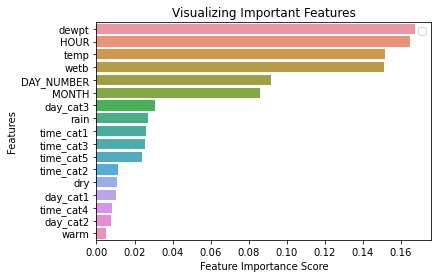

In [14]:
## show feature importances 

feature_imp = pd.Series(clf.feature_importances_,index=[ 'dry', 'warm', 'DAY_NUMBER', 'HOUR', 'MONTH', 'rain', 'temp', 'wetb', 'dewpt','day_cat1', 'day_cat2', 'day_cat3', 'time_cat1', 'time_cat2', 'time_cat3', 'time_cat4', 'time_cat5']).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

[15:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 91.02%


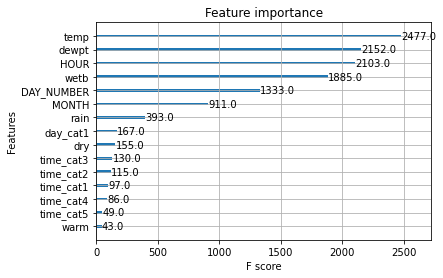

In [43]:
# train-test split evaluation of xgboost model
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance

ml_classifier_data_xgb = ml_classifier_data
ml_classifier_data_xgb['dewpt'] = pd.factorize(ml_classifier_data_xgb['dewpt'])[0]
ml_classifier_data_xgb['wetb'] = pd.factorize(ml_classifier_data_xgb['wetb'])[0]
ml_classifier_data_xgb["OCC_GROUP"] = ml_classifier_data_xgb['OCCUPANCY_PCT'].apply(bin_occupancy)
ml_classifier_data_xgb["OCC_GROUP"] = ml_classifier_data_xgb["OCC_GROUP"] * 10
ml_classifier_data_xgb["OCC_GROUP"] = ml_classifier_data_xgb["OCC_GROUP"].astype(int)
ml_classifier_data_xgb.sample()

X = ml_classifier_data_xgb.drop(['OCCUPANCY_PCT', "OCC_GROUP"], axis = 1)
Y = ml_classifier_data_xgb[["OCC_GROUP"]] 


data_dmatrix = xgb.DMatrix(data=X,label=Y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

plot_importance(model)
pyplot.show()

In [38]:
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model, X, Y, cv=kfold)

# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[15:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

NameError: name 'params' is not defined